In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from timeit import default_timer as timer
from datetime import timedelta
import os
import sys
import pickle
from timeit import default_timer as timer
from datetime import timedelta
from IPython.display import clear_output

import gym

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [2]:
seed = 1

os.environ['PYTHONHASHSEED'] = str(seed) # 为了禁止hash随机化，使得实验可复现。

random.seed(seed)
np.random.seed(seed)

# env.seed(seed)  这个等创建了环境之后再设置

torch.manual_seed(seed)            # 为CPU设置随机种子
torch.cuda.manual_seed(seed)       # 为当前GPU设置随机种子
torch.cuda.manual_seed_all(seed)   # 为所有GPU设置随机种子

In [3]:
path = os.path.abspath('..')
if path not in sys.path:
    sys.path.append(path)

In [4]:
from configs import Config
from replay_memories import PrioritizedReplayMemory
from networks_pytorch import MLP_pytorch
from agents_pytorch import DQNAgentPytorch

# Training Loop

从这里开始修改了一下评估的准则，原来是看self.rewards的后100个的均值超过游戏通关条件就停止，

考虑到训练中每一个reward都是用不同的策略跑出来（每5个是用同样的策略），并不是严格意义上的用一个策略评估100次，

所以改成当self.rewards的后20个均值超过游戏通关条件时（这样可以节省一些时间，不用每次评估都去跑100次），

用当前策略跑100次游戏，如果均值超过通关条件则停止。

## CartPole-v0

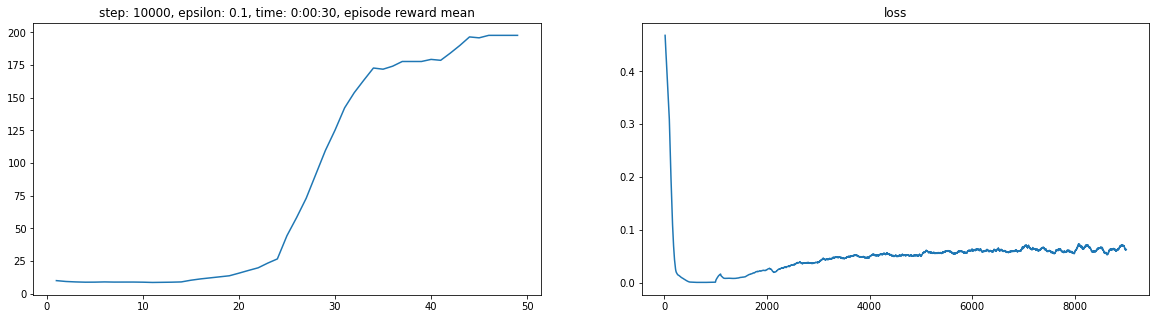

step: 11000, epsilon: 0.1, lr: 0.0001, time: 0:00:34
episode reward mean: 200.0, epsisode reward max: 200.0, episode length mean: 200.0, episode length max: 200, loss: 0.06974562034010887
[(0.8204789757728577, -0.8584960103034973, 0.08389373868703842, -0.06470336765050888), (0.5791619420051575, -0.5315273404121399, 0.09440316259860992, -0.08103462308645248), (0.5859923362731934, -0.5141369700431824, 0.012163850478827953, -0.022131826728582382), (0.1747712790966034, -0.15384164452552795, 0.017519565299153328, -0.02996395342051983), (0.4528597593307495, -0.6230894327163696, 0.007349594496190548, -0.010336178354918957), (0.10890136659145355, -0.09875910729169846, 0.005793201271444559, -0.007805441040545702), (0.34907853603363037, -0.48265835642814636, 0.002604853827506304, -0.13412150740623474), (0.00011130546045023948, -0.0624370239675045, -0.014474182389676571, -0.019051063805818558)]
a new render begins
step: 11000, epsilon: 0.1, time: 0:00:34
episode reward mean: 200.0, epsisode rewar

In [12]:
name = 'CartPole-v0'
env_eval = gym.make(name)
env_eval.seed(seed)


config = Config()
# config.epsilon_start = 1.
# config.epsilon_end = 0.01

start = timer()

dqn_agent = DQNAgentPytorch(env_name=name, network=MLP_pytorch, double=False, prioritized=True, config=config)

obs = dqn_agent.env.reset()
for step in range(1, config.max_steps+1):
    epsilon = config.epsilon_by_step(step)
    
    action = dqn_agent.get_action(obs, epsilon)
    pre_obs = obs
    obs, reward, done, _ = dqn_agent.env.step(action)
    
    dqn_agent.memory.add((pre_obs, action, reward, obs, done))
    
    dqn_agent.train(step)
    
    if done:
        obs = dqn_agent.env.reset()
        
    if step % 1000 == 0:
        mean_returns, max_returns, mean_lengths, max_lengths = dqn_agent.eval_(env_eval, 5)
        
        print('step: {}, epsilon: {}, lr: {}, time: {}'.format(step, epsilon, dqn_agent.optimizer.param_groups[0]['lr'], timedelta(seconds=int(timer()-start))))
        print('episode reward mean: {}, epsisode reward max: {}, episode length mean: {}, episode length max: {}, loss: {}'.format(
            mean_returns,
            max_returns,
            mean_lengths,
            max_lengths,
            np.array(dqn_agent.losses[-10:]).mean()))
        print('=========================================')
        print([(param.data.max().item(), param.data.min().item(), param.grad.data.max().item(), param.grad.data.min().item()) for param in dqn_agent.model.parameters()])
        print('=========================================')
        
    if step % 10000 == 0:
        clear_output(True)
        
        clear_output(True)
        plt.figure(figsize=(20, 5))
        plt.subplot(121)
        plt.title('step: {}, epsilon: {}, time: {}, episode reward mean'.format(step, epsilon, timedelta(seconds=int(timer()-start))))
        plt.plot(pd.Series(dqn_agent.rewards).rolling(10, 2).mean())
        plt.subplot(122)
        plt.title('loss')
        plt.plot(pd.Series(dqn_agent.losses).rolling(100, 20).mean())
        plt.show()
    
    if np.array(dqn_agent.rewards[-20:]).mean() > 195:  # 一开始会报一个warning: RuntimeWarning: Mean of empty slice， 可以忽略
        print('a new render begins')
        mean_returns, max_returns, mean_lengths, max_lengths = dqn_agent.eval_(env_eval, 100)
        print('step: {}, epsilon: {}, time: {}'.format(step, epsilon, timedelta(seconds=int(timer()-start))))
        print('episode reward mean: {}, epsisode reward max: {}, episode length mean: {}, episode length max: {}'.format(
            mean_returns,
            max_returns,
            mean_lengths,
            max_lengths))
        if mean_returns > 195:
            break 
        
# dqn_agent.render(env_eval)

In [9]:
mean_returns, max_returns, mean_lengths, max_lengths = dqn_agent.eval_(env_eval, 100)
print(mean_returns)

199.49


In [11]:
dqn_agent.render(env_eval)

In [10]:
torch.save(dqn_agent.model.state_dict(), 'dqn_prioritized_cartpole.pt')